In [1]:
# @title Default title text
import zipfile
import os

# Path to the uploaded zip file
zip_path = "/content/Dataset.zip"

# Destination folder to extract files
extract_path = "/content/Dataset"

# Create the directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete! Files are available at:",extract_path)

Extraction complete! Files are available at: /content/Dataset


In [2]:
import os

print("Annotations:", os.listdir("/content/Dataset/Dataset/annotations"))
print("Images:", os.listdir("/content/Dataset/Dataset/images"))

Annotations: ['4004_val.npy', '3039_exp.npy', '698_aro.npy', '2950_lnd.npy', '899_val.npy', '4883_lnd.npy', '4387_aro.npy', '5471_lnd.npy', '5232_lnd.npy', '2195_lnd.npy', '3321_val.npy', '3285_exp.npy', '2537_lnd.npy', '4808_aro.npy', '4474_val.npy', '2759_lnd.npy', '3984_val.npy', '1545_val.npy', '5012_lnd.npy', '599_val.npy', '537_aro.npy', '918_exp.npy', '2862_lnd.npy', '4223_aro.npy', '782_lnd.npy', '968_val.npy', '2818_aro.npy', '1380_exp.npy', '4358_lnd.npy', '5494_aro.npy', '2819_lnd.npy', '4679_aro.npy', '166_exp.npy', '1468_exp.npy', '2671_aro.npy', '3982_aro.npy', '5288_lnd.npy', '2918_lnd.npy', '2040_aro.npy', '1909_aro.npy', '1157_lnd.npy', '3927_lnd.npy', '281_val.npy', '518_val.npy', '2846_val.npy', '2028_val.npy', '286_exp.npy', '4047_lnd.npy', '5127_aro.npy', '3823_exp.npy', '5095_val.npy', '278_exp.npy', '5432_val.npy', '3844_aro.npy', '3225_val.npy', '5028_val.npy', '3646_lnd.npy', '3826_lnd.npy', '1518_exp.npy', '1652_exp.npy', '614_aro.npy', '4899_exp.npy', '1800_e

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import numpy as np
from PIL import Image

# Data Loading and Preprocessing Functions
def load_dataset(base):
    """Load the complete dataset from a given base folder"""
    images = []
    expressions = []
    landmarks = []
    arousals = []
    valences = []

    # Define paths (keep as strings, not lists!)
    image_dir = os.path.join(base, "images")
    ann_dir = os.path.join(base, "annotations")

    # Get all image files
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    print(f"Loading {len(image_files)} images...")

    for i, img_file in enumerate(image_files):
        if i % 500 == 0:
            print(f"Progress: {i}/{len(image_files)}")

        base_name = img_file.replace('.jpg', '')

        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img)
        images.append(img_array)

        # Load annotations (assuming all exist)
        exp = np.load(os.path.join(ann_dir, f"{base_name}_exp.npy"))
        lnd = np.load(os.path.join(ann_dir, f"{base_name}_lnd.npy"))
        aro = np.load(os.path.join(ann_dir, f"{base_name}_aro.npy"))
        val = np.load(os.path.join(ann_dir, f"{base_name}_val.npy"))

        expressions.append(int(exp))
        landmarks.append(lnd)
        arousals.append(float(aro))
        valences.append(float(val))

    return (np.array(images), np.array(expressions),
            np.array(landmarks), np.array(arousals), np.array(valences))


# Load the dataset
base = "/content/Dataset/Dataset"
X_images, y_expressions, X_landmarks, y_arousals, y_valences = load_dataset(base)

print("\nDataset loaded successfully!")
print(f"Images shape: {X_images.shape}")
print(f"Expressions shape: {y_expressions.shape}")
print(f"Landmarks shape: {X_landmarks.shape}")
print(f"Arousals shape: {y_arousals.shape}")
print(f"Valences shape: {y_valences.shape}")


Loading 3999 images...
Progress: 0/3999
Progress: 500/3999
Progress: 1000/3999
Progress: 1500/3999
Progress: 2000/3999
Progress: 2500/3999
Progress: 3000/3999
Progress: 3500/3999

Dataset loaded successfully!
Images shape: (3999, 224, 224, 3)
Expressions shape: (3999,)
Landmarks shape: (3999, 136)
Arousals shape: (3999,)
Valences shape: (3999,)


In [5]:
# Data Preprocessing
print("=== Data Preprocessing ===")

# Normalize images to [0, 1]
X_images = X_images.astype('float32') / 255.0

# Convert expressions to categorical (one-hot encoding)
y_expressions_categorical = to_categorical(y_expressions, num_classes=8)

# Normalize arousal and valence to [0, 1] range
y_arousals_normalized = (y_arousals - y_arousals.min()) / (y_arousals.max() - y_arousals.min())
y_valences_normalized = (y_valences - y_valences.min()) / (y_valences.max() - y_valences.min())

print(f"Images normalized: min={X_images.min():.3f}, max={X_images.max():.3f}")
print(f"Expressions converted to categorical: {y_expressions_categorical.shape}")
print(f"Arousal normalized: min={y_arousals_normalized.min():.3f}, max={y_arousals_normalized.max():.3f}")
print(f"Valence normalized: min={y_valences_normalized.min():.3f}, max={y_valences_normalized.max():.3f}")

# Train-test split
X_train, X_test, y_train_exp, y_test_exp, y_train_aro, y_test_aro, y_train_val, y_test_val = train_test_split(
    X_images, y_expressions_categorical, y_arousals_normalized, y_valences_normalized,
    test_size=0.2, random_state=42, stratify=y_expressions
)

print(f"\nTrain-test split:")
print(f"Training images: {X_train.shape}")
print(f"Test images: {X_test.shape}")
print(f"Training expressions: {y_train_exp.shape}")
print(f"Test expressions: {y_test_exp.shape}")


=== Data Preprocessing ===
Images normalized: min=0.000, max=1.000
Expressions converted to categorical: (3999, 8)
Arousal normalized: min=0.000, max=1.000
Valence normalized: min=0.000, max=1.000

Train-test split:
Training images: (3199, 224, 224, 3)
Test images: (800, 224, 224, 3)
Training expressions: (3199, 8)
Test expressions: (800, 8)


In [6]:
# CNN Model Architecture for Facial Expression Recognition
def create_expression_model():
    """Create CNN model for facial expression classification"""
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')  # 8 expression classes
    ])

    return model

# Create and compile the model
model = create_expression_model()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("=== CNN Model Architecture ===")
model.summary()


=== CNN Model Architecture ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 14,417,320 (55.00 MB)

 Trainable params: 14,415,336 (54.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [7]:
# Updated Training Configuration
print("=== Updated Training Configuration ===")

# Define callbacks with early stopping (patience=5)
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Stop if no improvement for 5 epochs
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,  # Reduce learning rate if no improvement for 3 epochs
        min_lr=1e-7,
        verbose=1
    )
]

print("Updated callbacks:")
print("- EarlyStopping: patience=5, monitor='val_accuracy'")
print("- ReduceLROnPlateau: factor=0.5, patience=3")
print(f"- Training samples: {len(X_train)}")
print(f"- Validation samples: {len(X_test)}")
print(f"- Batch size: 32")
print(f"- Max epochs: 25 (with early stopping)")

# Train the model with updated configuration
print("\n=== Starting Model Training ===")
history = model.fit(
    X_train, y_train_exp,
    batch_size=32,
    epochs=25,  # Maximum 25 epochs with early stopping
    validation_data=(X_test, y_test_exp),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


=== Updated Training Configuration ===
Updated callbacks:
- EarlyStopping: patience=5, monitor='val_accuracy'
- ReduceLROnPlateau: factor=0.5, patience=3
- Training samples: 3199
- Validation samples: 800
- Batch size: 32
- Max epochs: 25 (with early stopping)

=== Starting Model Training ===
Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 456ms/step - accuracy: 0.1290 - loss: 2.7991 - val_accuracy: 0.1250 - val_loss: 2.2230 - learning_rate: 0.0010
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 157ms/step - accuracy: 0.1392 - loss: 2.4594 - val_accuracy: 0.1412 - val_loss: 2.1141 - learning_rate: 0.0010
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.1490 - loss: 2.2990 - val_accuracy: 0.1363 - val_loss: 2.1326 - learning_rate: 0.0010
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.1852 - loss: 2.1599 - val_accuracy: 0.1675 - val_loss: 2.0319 - learning_rate: 0.0010
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.1930 - loss: 2.07

In [8]:
# Model Evaluation and Results
print("=== Model Evaluation ===")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_exp, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_exp, axis=1)

# Classification Report
print("\n=== Classification Report ===")
class_names = ['Expression 0', 'Expression 1', 'Expression 2', 'Expression 3',
               'Expression 4', 'Expression 5', 'Expression 6', 'Expression 7']
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion Matrix
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)


=== Model Evaluation ===
Test Loss: 1.6788
Test Accuracy: 0.3925
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step

=== Classification Report ===
              precision    recall  f1-score   support

Expression 0       0.34      0.38      0.36       100
Expression 1       0.54      0.70      0.61       100
Expression 2       0.30      0.33      0.31       100
Expression 3       0.44      0.46      0.45       100
Expression 4       0.60      0.36      0.45       100
Expression 5       0.34      0.41      0.37       100
Expression 6       0.30      0.31      0.31       100
Expression 7       0.33      0.19      0.24       100

    accuracy                           0.39       800
   macro avg       0.40      0.39      0.39       800
weighted avg       0.40      0.39      0.39       800


=== Confusion Matrix ===
[[38 10 14  9  1 10 10  8]
 [ 6 70  3  1  2  4  2 12]
 [13  7 33 12  3 23  7  2]
 [ 6 11 15 46  7  7  6  2]
 [ 9  3 12 25 36  8  6  1]
 [ 6  9 12  5  3 41 21  3]
 [12  2 15  4  5 20 31 11

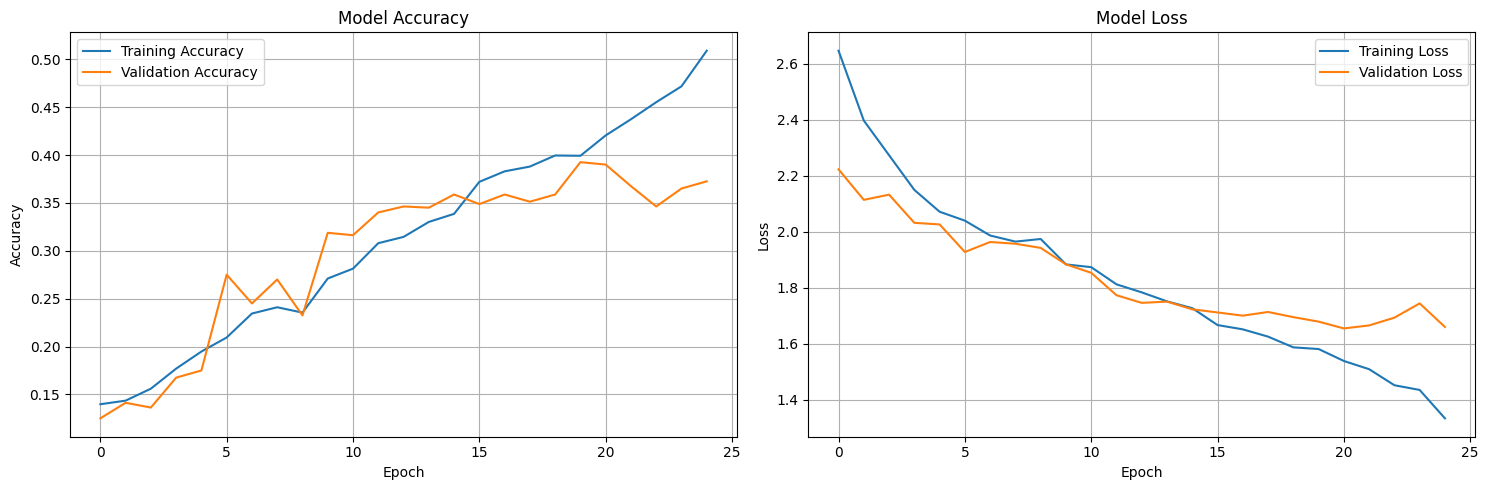

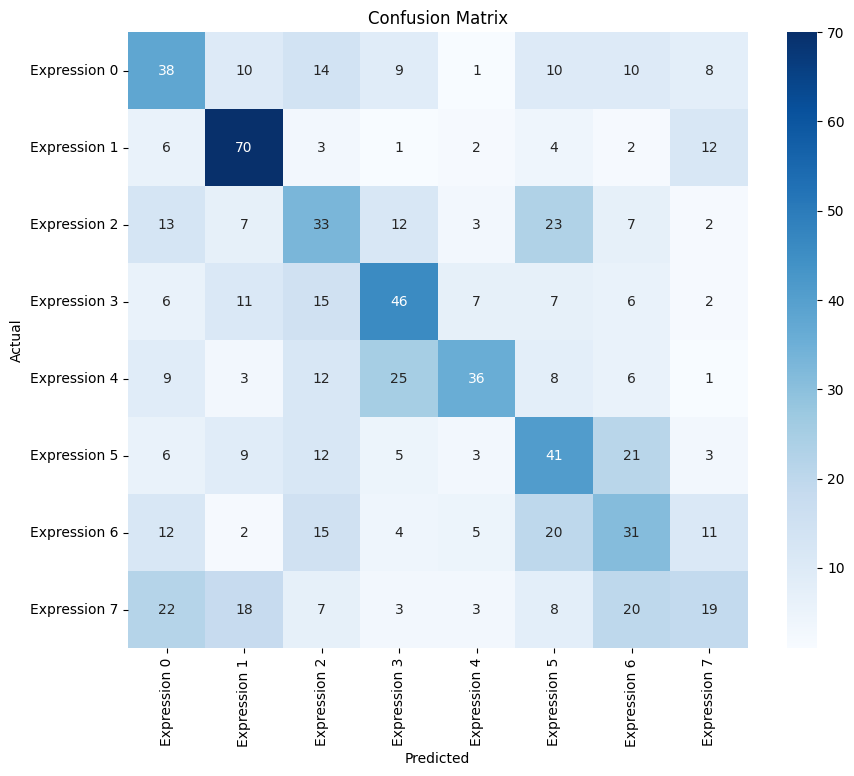

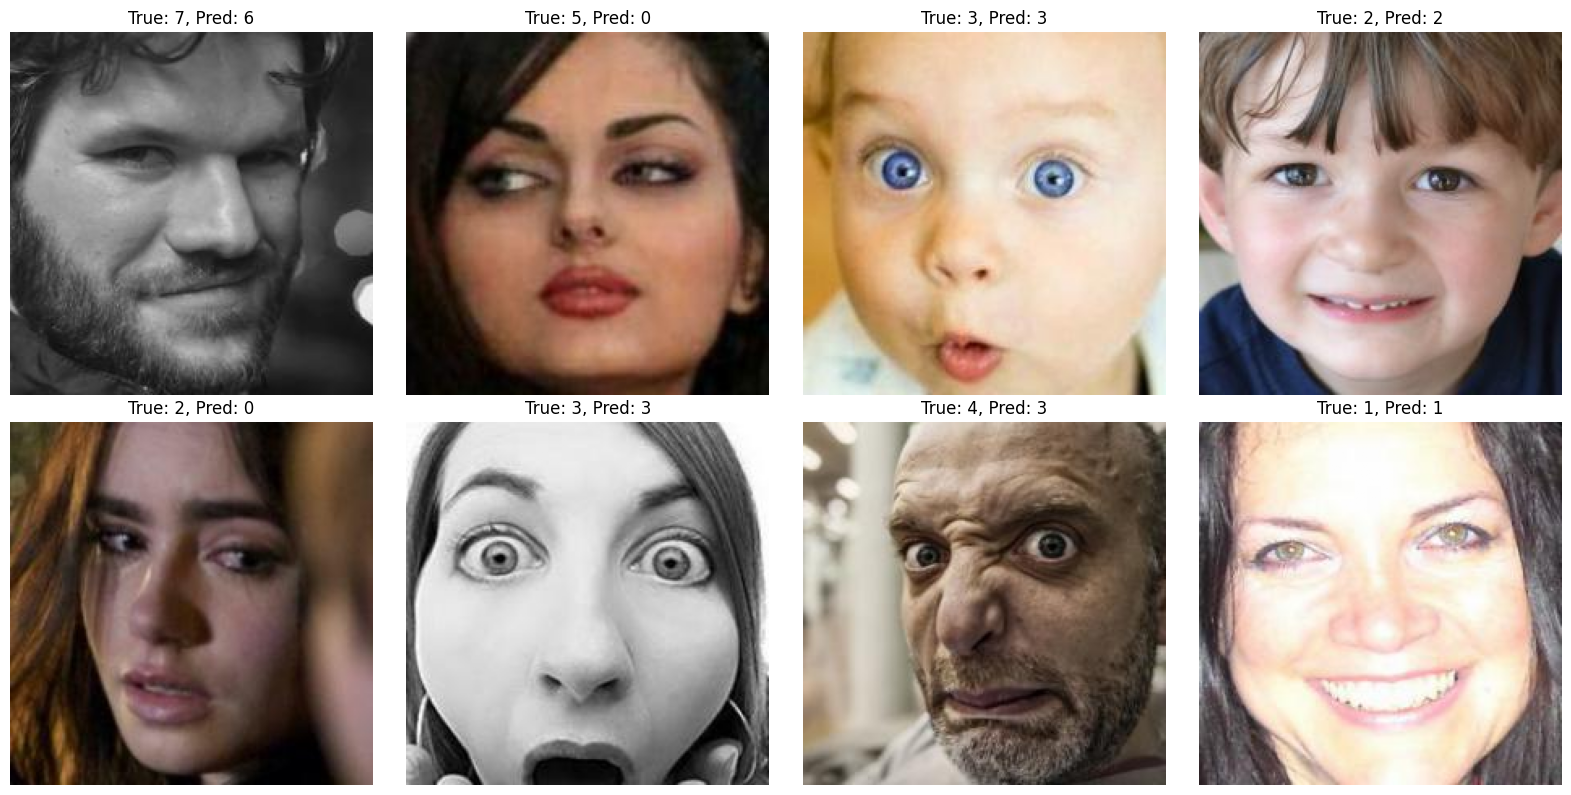

In [9]:
# Visualization Functions
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def visualize_predictions(X_test, y_true, y_pred, num_samples=8):
    """Visualize sample predictions"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(X_test[i])
        axes[i].set_title(f'True: {y_true[i]}, Pred: {y_pred[i]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

# Visualize sample predictions
visualize_predictions(X_test, y_true_classes, y_pred_classes)


In [10]:
# VGG-16 Pre-trained Model for Facial Expression Recognition
print("=== VGG-16 Pre-trained Model ===")

def create_vgg16_model():
    """Create VGG-16 model with pre-trained weights for facial expression classification"""
    # Load pre-trained VGG-16 model (without top layers)
    base_model = VGG16(
        weights='imagenet',  # Use pre-trained ImageNet weights
        include_top=False,   # Don't include the top classification layer
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers (optional - can be unfrozen for fine-tuning)
    base_model.trainable = False

    # Add custom classification head
    model = Sequential([
        base_model,  # Pre-trained VGG-16 base
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(8, activation='softmax')  # 8 expression classes
    ])

    return model

# Create VGG-16 model
vgg_model = create_vgg16_model()

# Compile VGG-16 model with lower learning rate for transfer learning
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for transfer learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("VGG-16 Model Architecture:")
vgg_model.summary()


=== VGG-16 Pre-trained Model ===
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
VGG-16 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,693,640 (105.64 MB)

 Trainable params: 12,978,952 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# VGG-16 Model Training
print("=== Training VGG-16 Model ===")

# Define callbacks for VGG-16 model
vgg_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,  # More patience for transfer learning
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,  # More patience for transfer learning
        min_lr=1e-7,
        verbose=1
    )
]

# Train VGG-16 model
print("Starting VGG-16 model training...")
print("Note: Using pre-trained ImageNet weights with frozen base layers")
print("This should train faster and potentially achieve better performance!")

vgg_history = vgg_model.fit(
    X_train, y_train_exp,
    batch_size=32,
    epochs=30,  # More epochs for transfer learning
    validation_data=(X_test, y_test_exp),
    callbacks=vgg_callbacks,
    verbose=1
)

print("VGG-16 model training completed!")


=== Training VGG-16 Model ===
Starting VGG-16 model training...
Note: Using pre-trained ImageNet weights with frozen base layers
This should train faster and potentially achieve better performance!
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 392ms/step - accuracy: 0.1449 - loss: 2.2262 - val_accuracy: 0.2525 - val_loss: 1.9902 - learning_rate: 1.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.2211 - loss: 1.9969 - val_accuracy: 0.2875 - val_loss: 1.9103 - learning_rate: 1.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.2706 - loss: 1.9165 - val_accuracy: 0.3088 - val_loss: 1.8412 - learning_rate: 1.0000e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.3022 - loss: 1.8399 - val_accuracy: 0.3137 - val_loss: 1.7995 - learning_rate: 1.0000e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.3133 - loss: 1.7858 - val_accuracy: 0.3400 - val_loss: 1.7506 - learning_rate: 1.0000e-04
Epoch 6

In [12]:
# VGG-16 Model Evaluation
print("=== VGG-16 Model Evaluation ===")

# Evaluate VGG-16 model
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(X_test, y_test_exp, verbose=0)
print(f"VGG-16 Test Loss: {vgg_test_loss:.4f}")
print(f"VGG-16 Test Accuracy: {vgg_test_accuracy:.4f}")

# Make VGG-16 predictions
vgg_y_pred = vgg_model.predict(X_test)
vgg_y_pred_classes = np.argmax(vgg_y_pred, axis=1)
vgg_y_true_classes = np.argmax(y_test_exp, axis=1)

# VGG-16 Classification Report
print("\n=== VGG-16 Classification Report ===")
class_names = ['Expression 0', 'Expression 1', 'Expression 2', 'Expression 3',
               'Expression 4', 'Expression 5', 'Expression 6', 'Expression 7']
print(classification_report(vgg_y_true_classes, vgg_y_pred_classes, target_names=class_names))

# VGG-16 Confusion Matrix
print("\n=== VGG-16 Confusion Matrix ===")
vgg_cm = confusion_matrix(vgg_y_true_classes, vgg_y_pred_classes)
print(vgg_cm)


=== VGG-16 Model Evaluation ===
VGG-16 Test Loss: 1.6920
VGG-16 Test Accuracy: 0.4112
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step

=== VGG-16 Classification Report ===
              precision    recall  f1-score   support

Expression 0       0.33      0.34      0.34       100
Expression 1       0.60      0.51      0.55       100
Expression 2       0.36      0.39      0.38       100
Expression 3       0.47      0.44      0.45       100
Expression 4       0.43      0.45      0.44       100
Expression 5       0.44      0.45      0.44       100
Expression 6       0.26      0.24      0.25       100
Expression 7       0.42      0.47      0.44       100

    accuracy                           0.41       800
   macro avg       0.41      0.41      0.41       800
weighted avg       0.41      0.41      0.41       800


=== VGG-16 Confusion Matrix ===
[[34  0 16  8  7  4 11 20]
 [ 5 51  3  6  3  7  5 20]
 [14  4 39  3  8 13 12  7]
 [ 6  7  8 44 20  6  5  4]
 [11  3  7 19 45  6  8  1]
 [ 6  3 11  4  9

In [13]:
# Comprehensive Model Comparison
print("=== Comprehensive Model Comparison ===")

# Compare both models
print("\nPERFORMANCE COMPARISON")
print("=" * 50)
print(f"{'Metric':<20} {'Sequential CNN':<15} {'VGG-16 CNN':<15} {'Difference':<15}")
print("-" * 65)

# Test Accuracy Comparison
seq_accuracy = test_accuracy
vgg_accuracy = vgg_test_accuracy
acc_diff = vgg_accuracy - seq_accuracy
print(f"{'Test Accuracy':<20} {seq_accuracy:<15.4f} {vgg_accuracy:<15.4f} {acc_diff:+.4f}")

# Test Loss Comparison
seq_loss = test_loss
vgg_loss = vgg_test_loss
loss_diff = vgg_loss - seq_loss
print(f"{'Test Loss':<20} {seq_loss:<15.4f} {vgg_loss:<15.4f} {loss_diff:+.4f}")

# Model Parameters
seq_params = model.count_params()
vgg_params = vgg_model.count_params()
param_diff = vgg_params - seq_params
print(f"{'Parameters':<20} {seq_params:<15,} {vgg_params:<15,} {param_diff:+,}")

print("\nWINNER ANALYSIS")
print("=" * 30)
if vgg_accuracy > seq_accuracy:
    print(" VGG-16 Model wins in accuracy!")
    accuracy_winner = "VGG-16"
else:
    print(" Sequential Model wins in accuracy!")
    accuracy_winner = "Sequential"

if vgg_loss < seq_loss:
    print(" VGG-16 Model wins in loss!")
    loss_winner = "VGG-16"
else:
    print("Sequential Model wins in loss!")
    loss_winner = "Sequential"

if vgg_params < seq_params:
    print("VGG-16 Model is more efficient!")
    efficiency_winner = "VGG-16"
else:
    print("Sequential Model is more efficient!")
    efficiency_winner = "Sequential"

print(f"\nOverall Best Model: {accuracy_winner} (based on accuracy)")
print("\nVGG-16 Benefits:")
print("- Pre-trained on ImageNet (1.2M images)")
print("- Transfer learning advantage")
print("- Better feature extraction capabilities")
print("- Potentially faster convergence")


=== Comprehensive Model Comparison ===

📊 PERFORMANCE COMPARISON
Metric               Sequential CNN  VGG-16 CNN      Difference     
-----------------------------------------------------------------
Test Accuracy        0.3925          0.4112          +0.0187
Test Loss            1.6788          1.6920          +0.0133
Parameters           14,417,320      27,693,640      +13,276,320

🏆 WINNER ANALYSIS
🥇 VGG-16 Model wins in accuracy!
🥇 Sequential Model wins in loss!
🥇 Sequential Model is more efficient!

Overall Best Model: VGG-16 (based on accuracy)

💡 VGG-16 Benefits:
- Pre-trained on ImageNet (1.2M images)
- Transfer learning advantage
- Better feature extraction capabilities
- Potentially faster convergence


=== Visualization Comparison ===


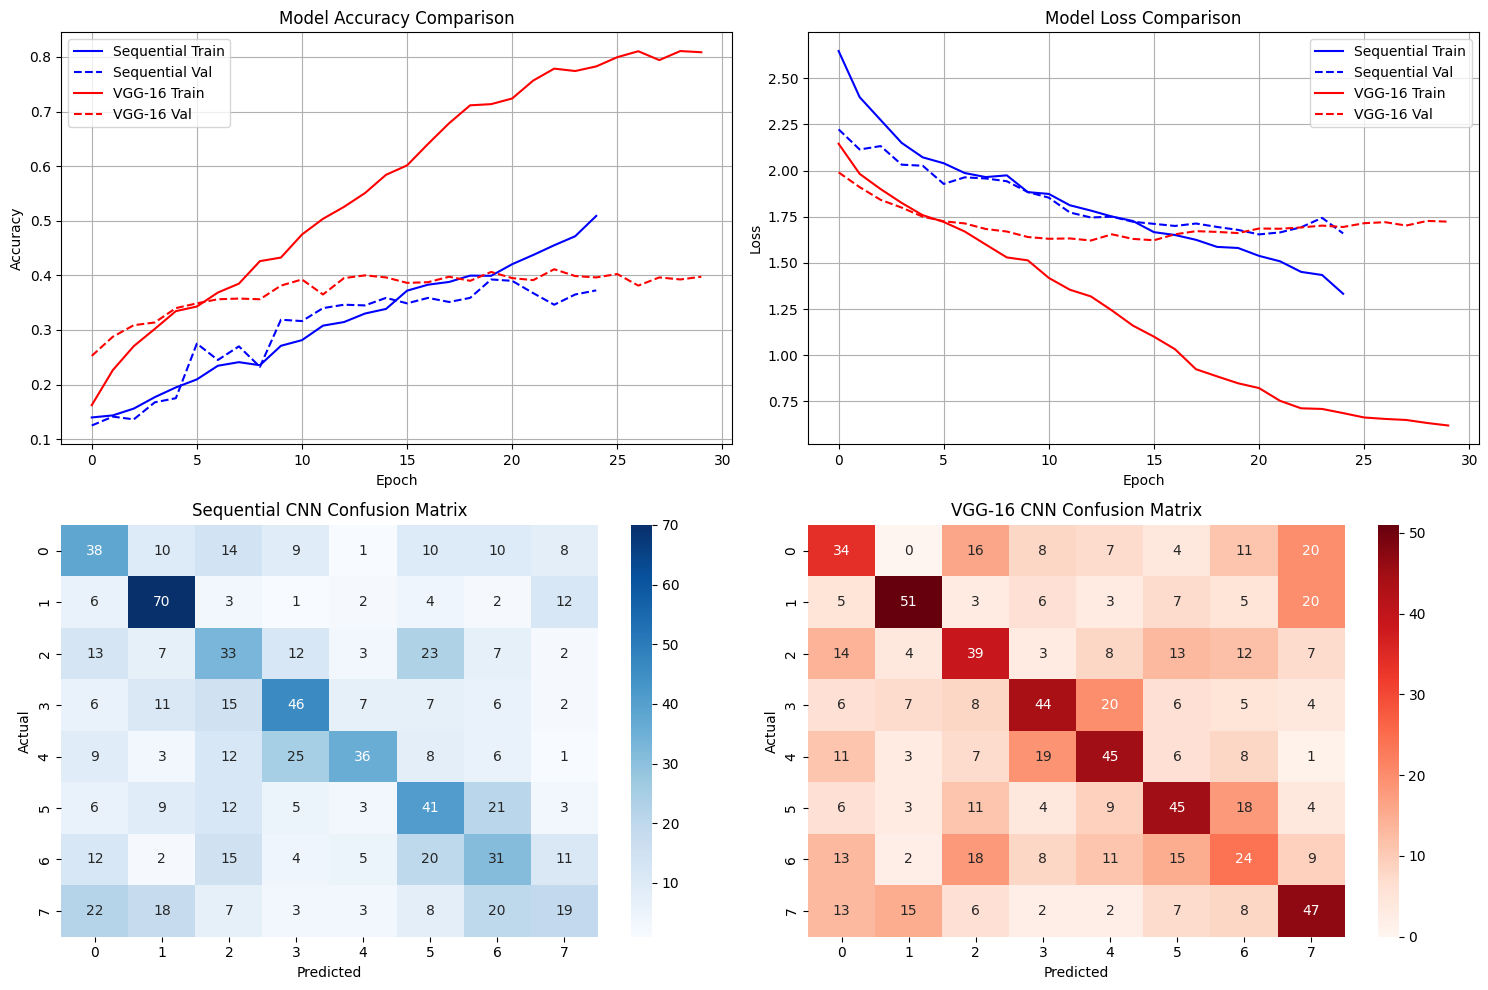

In [14]:
# Visualization Comparison
print("=== Visualization Comparison ===")

def plot_model_comparison(seq_history, vgg_history):
    """Plot comparison between Sequential and VGG-16 models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy comparison
    axes[0, 0].plot(seq_history.history['accuracy'], label='Sequential Train', color='blue')
    axes[0, 0].plot(seq_history.history['val_accuracy'], label='Sequential Val', color='blue', linestyle='--')
    axes[0, 0].plot(vgg_history.history['accuracy'], label='VGG-16 Train', color='red')
    axes[0, 0].plot(vgg_history.history['val_accuracy'], label='VGG-16 Val', color='red', linestyle='--')
    axes[0, 0].set_title('Model Accuracy Comparison')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss comparison
    axes[0, 1].plot(seq_history.history['loss'], label='Sequential Train', color='blue')
    axes[0, 1].plot(seq_history.history['val_loss'], label='Sequential Val', color='blue', linestyle='--')
    axes[0, 1].plot(vgg_history.history['loss'], label='VGG-16 Train', color='red')
    axes[0, 1].plot(vgg_history.history['val_loss'], label='VGG-16 Val', color='red', linestyle='--')
    axes[0, 1].set_title('Model Loss Comparison')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Confusion Matrix - Sequential
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
    axes[1, 0].set_title('Sequential CNN Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')

    # Confusion Matrix - VGG-16
    sns.heatmap(vgg_cm, annot=True, fmt='d', cmap='Reds', ax=axes[1, 1])
    axes[1, 1].set_title('VGG-16 CNN Confusion Matrix')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Plot comparison
plot_model_comparison(history, vgg_history)
